# Mini-Challenge #2: predicting the book rating according to a review


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# loading training and test data
from google.colab import drive
drive.mount('/content/gdrive')
tr_PATH = './gdrive/My Drive/DL/Projects/Book Rating/MC2.csv' # training set
ts_PATH = './gdrive/My Drive/DL/Projects/Book Rating/MC2test.csv' # test set

tr = pd.read_csv(tr_PATH).set_index('Unnamed: 0')
ts = pd.read_csv(ts_PATH).set_index('Unnamed: 0')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Data Preprocessing

In [0]:
tr = tr.dropna()

tr.star_rating = tr.star_rating.astype('category')

tr.verified_purchase = tr.verified_purchase.astype('category')
ts.verified_purchase = ts.verified_purchase.astype('category')

# concatenate review headline and review body to a new variable "review"
tr['review'] = tr['review_headline'].str.cat(tr[['review_body']], sep='. ')
ts['review'] = ts['review_headline'].str.cat(ts[['review_body']], sep='. ')

X = tr['review'].astype(str)
y = tr['star_rating']

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 16000 # We will keep only the 16k most common words

tokenizer = Tokenizer(num_words=max_words) 
tokenizer.fit_on_texts(X) 
sequences = tokenizer.texts_to_sequences(X) # list: string - numbers(indices)
word_index = tokenizer.word_index # dict: word - number(index)

print('Found {} unique tokens.'.format(len(word_index)))

# word_index is a dictionary that maps the word to its corresponding index in the vocabulary:
w1 = "cat"
print("Index of", w1, "in the vocabulary: ", word_index[w1])

# sequences is a tuple of lists denoting the corresponding indices of the words in each string (review):
print('The indices of words in the number', sequences.index(sequences[4]),'review:', sequences[4])

Found 726132 unique tokens.
Index of cat in the vocabulary:  1580
The indices of words in the number 4 review: [305, 52, 921, 42, 85, 9, 10, 6, 2656, 4, 111, 42, 35, 768, 8, 66, 8, 524, 20, 814, 41, 6, 130, 17, 35, 820, 6469, 8, 1, 929, 9289, 112, 89, 52, 463, 6, 23, 276, 36, 34, 399, 307, 1, 91, 3, 5542, 99, 6518, 63, 34, 175, 4, 78, 11, 2, 81, 1986, 1275, 254, 384, 7, 503, 5, 2096, 3340, 4, 249, 5, 51, 66, 20, 61, 11, 322, 4, 403, 56, 403, 425, 42, 4, 66, 84, 62, 4940, 13, 13, 2, 317, 138, 9, 10, 305, 52, 648, 5, 229, 305, 140, 6, 110, 41, 11, 322, 140, 4, 7, 9, 174, 5, 166, 3, 4029, 12, 6, 2, 74, 227, 358, 112, 783, 15, 41, 27, 300, 16, 1, 554, 2897, 3, 66, 4940, 5101, 88, 249, 5, 254, 36, 34, 74, 227, 23, 1983, 2869, 4, 78, 203, 176, 14, 376, 1, 1019, 49, 3, 1, 185, 40, 3780, 632, 582, 349, 6, 3780, 4, 1, 1829, 2, 268, 2836, 1, 11716, 1019, 1387, 3, 5, 443, 840, 40, 806, 282, 33, 2999, 14538, 13, 13, 38, 43, 18, 21, 358, 207, 14, 5, 354, 26, 19, 53, 4, 105, 1, 91, 3, 1, 6706, 1424,

In [8]:
# Furthermore, we need to pad the sequences so that their lengths are the same and do not exceed a specific maximum length.
maxlen = 256
X = pad_sequences(sequences, maxlen=maxlen)

# Transform the target "rating" to one-hot encoding
from sklearn.preprocessing import OneHotEncoder

y = np.asarray(y)
onehot_encoder = OneHotEncoder(sparse=False)
encoded = y.reshape(len(y), 1)
Y = onehot_encoder.fit_transform(encoded)

print('Shape of data tensor: ', X.shape)
print('Shape of label tensor: ', Y.shape)

Shape of data tensor:  (1099194, 256)
Shape of label tensor:  (1099194, 5)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


###Word Embedding using Pre-trained GloVe

In [9]:
# Map words with their word representations from GloVe pre-trained word embeddings
embeddings_index = {}
gl_PATH = './gdrive/My Drive/DL/NLP/glove.6B.200d.txt' # pretrained GloVe
f = open(gl_PATH)
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

# Create a embedding matrix for the Embedding() layer in the model, with the shape of (max_words, embedding_dim).
embedding_dim = 200
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items(): 
  if i < max_words:
    embedding_vector = embeddings_index.get(word) # Convert word of index i in the word_index to its word vector with 100 dimensions
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [0]:
# Split data into training, validation and test data sets.
from sklearn.model_selection import train_test_split

# train : val : test = 98 : 1 : 1
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.02, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=1)

In [11]:
!pip install keras-layer-normalization

### Model Evaluation 

In [12]:
# loading the models 
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Embedding, LSTM, Flatten, Dense, Input, Dropout, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Activation

from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras_layer_normalization import LayerNormalization

model_0 = load_model('./gdrive/My Drive/DL/Projects/Book Rating/M0630_7005.h5', custom_objects={'LayerNormalization': LayerNormalization})
model_1 = load_model('./gdrive/My Drive/DL/Projects/Book Rating/M0629_6672.h5', custom_objects={'LayerNormalization': LayerNormalization})
model_2 = load_model('./gdrive/My Drive/DL/Projects/Book Rating/M0629_6661.h5', custom_objects={'LayerNormalization': LayerNormalization})
model_3 = load_model('./gdrive/My Drive/DL/Projects/Book Rating/M0630_6603.h5', custom_objects={'LayerNormalization': LayerNormalization})
model_4 = load_model('./gdrive/My Drive/DL/Projects/Book Rating/M0630_6607.h5', custom_objects={'LayerNormalization': LayerNormalization})

W0630 15:46:31.349689 139953892235136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 15:46:31.409000 139953892235136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 15:46:31.414402 139953892235136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0630 15:46:31.436251 139953892235136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0630 15:46:31.571991 139953892235136 de

In [16]:
model_0.evaluate(X_test, y_test)

10992/10992 [==============================] - 25s 2ms/step


[0.704512714819096, 0.7286208151382824]

In [17]:
model_1.evaluate(X_test, y_test)

10992/10992 [==============================] - 49s 4ms/step


[0.6695302270211854, 0.7424490538573508]

In [18]:
model_2.evaluate(X_test, y_test)

10992/10992 [==============================] - 58s 5ms/step


[0.6717648685759332, 0.7424490538573508]

In [19]:
model_3.evaluate(X_test, y_test)

10992/10992 [==============================] - 58s 5ms/step


[0.664973534524354, 0.7445414847161572]

In [20]:
model_4.evaluate(X_test, y_test)

10992/10992 [==============================] - 49s 4ms/step


[0.6618741773274962, 0.7469068413391557]

In [0]:
pred_0 = model_0.predict(X_test)
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
pred_4 = model_4.predict(X_test)

In [0]:
# ensembling 4 models

pred_ens = 0.05 * pred_0 + 0.05 * pred_1 + 0.05 * pred_2 + 0.2 * pred_3 + 0.65 * pred_4 
# Conventionally, we assign a higher weight to the model that perform better than other ones.

#### Heatmap

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from string import ascii_uppercase
import seaborn as sn

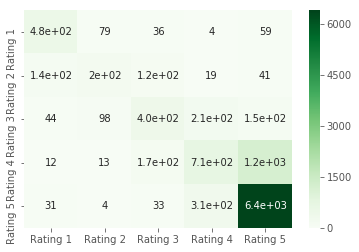

In [60]:
# Make a confusion matrix at first
matrix = confusion_matrix(y_test.argmax(axis=1), pred_ens.argmax(axis=1))

# Convert the matrix into a data frame as input for the heatmap
columns = ['Rating %s' %(i) for i in list('12345')[0:len(np.unique(y_test.argmax(axis=1)))]]
df_cm = pd.DataFrame(matrix, index=columns, columns=columns)
ax = sn.heatmap(df_cm, cmap='Greens', annot=True)

#### The heatmaps show the performance of the classifier, indicating how many predicted labels are equal to the true labels. We could see that the class of "Rating 5", which takes the majority of the samples in the data set, unsurprisingly get the highest number of the correctly classified labels. For each class, that is, in the one vs. all situation, the number of correctly classified labels is always the biggiest. However, this metric does not give us details of the predictions. In comparison, ROC metric evaluate the classifier according to the trade-offs between false positive rate and true positive rate, which is often used by the class imbalance problem. In the following ROC plot, we visualize the curves of each class as well as the micro- and macro-averaging ROC curve. While the macro-averaging method computes the metric for each class and then averages them , i.e. gives equal weight to each class, the micro-averaging method considers the contributions of each class when averaging, which should be preffered in the class imbalance situation.

#### ROC curve

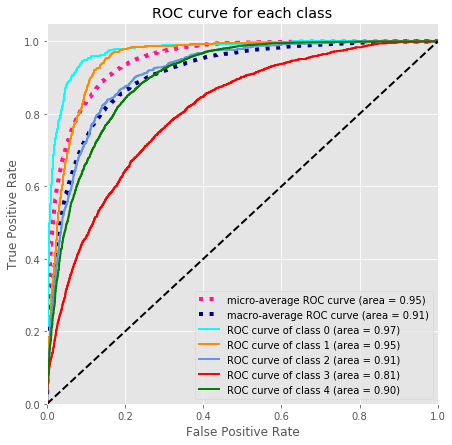

In [42]:
# The code is obtained from：https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

# Binarize the multiclass labels
Y_bi = label_binarize(Y, classes=[1,2,3,4,5])
n_classes = Y_bi.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_ens[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_ens.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for each class')
plt.legend(loc="lower right")
plt.show()

#### Precision - Recall curve

#### The precision-recall curve plots the trade-off between precision (the number of true positives over the number of true positives plus the number of false positives) and recall (the number of true positives over the number of true positives plus the number of false negatives). This metric takes care of both accurate (Precision) and positive (Recall) results, and thus takes into account the circumstance where there is large difference between positive and negative samples. Accordingly, in the following graph we could see that the scores from the PR curves are relatively lower than that from the ROC curves. However, the micro-average PR score of 0.83 still represents a fairly good quality of the classifier. 

Average precision score, micro-averaged over all classes: 0.83


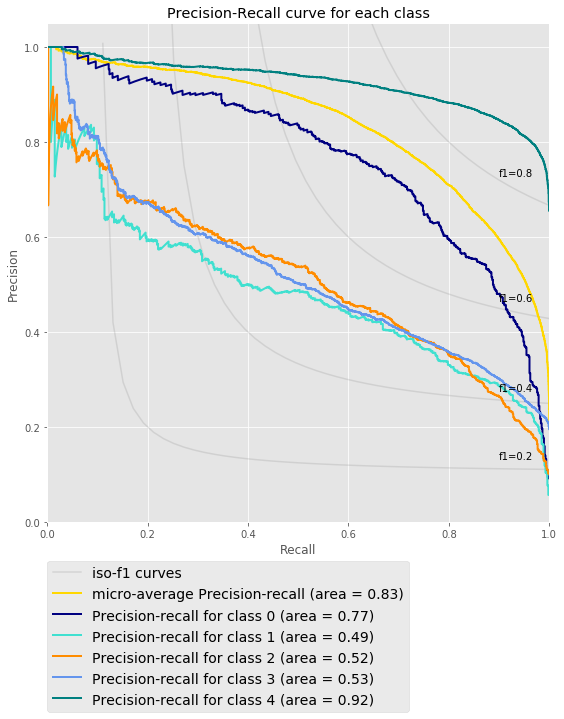

In [43]:
# Code based on: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        pred_ens[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], pred_ens[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    pred_ens.ravel())
average_precision["micro"] = average_precision_score(y_test, pred_ens,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'green'])

plt.figure(figsize=(9,11))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

### Making the Prediction

In [0]:
ts = ts['review'].astype(str)
tokenizer.fit_on_texts(ts) 
sequences = tokenizer.texts_to_sequences(ts)
word_index = tokenizer.word_index
ts = pad_sequences(sequences, maxlen=maxlen)

In [0]:
pred_0_ts = model_0.predict(ts)
pred_1_ts = model_1.predict(ts)
pred_2_ts = model_2.predict(ts)
pred_3_ts = model_3.predict(ts)
pred_4_ts = model_4.predict(ts)

In [0]:
pred_ens_ts = 0.05 * pred_0_ts + 0.05 * pred_1_ts + 0.05 * pred_2_ts + 0.2 * pred_3_ts + 0.65 * pred_4_ts

In [0]:
ts_PATH = './gdrive/My Drive/DL/Projects/Book Rating/MC2test.csv' # test set

test = pd.read_csv(ts_PATH).set_index('Unnamed: 0')

In [0]:
pred = np.argmax(pred_ens_ts, axis=1) + 1

In [0]:
test['star_rating'] = pred
test[['product_id', 'star_rating']].to_csv('./gdrive/My Drive/DL/Projects/Book Rating/pred.csv')

### Discussion

#### We keep in mind that there remains sufficient space for improving our performance. In fact, almost each step can be done better. 

#### To start with, using tokenizer that is sentiment-aware should be a good idea: it can isolate emiticons, preserves capitalizations which might be written on purpose and thus entail some emotional information etc.. 

#### Moreover, although we prefer working on the raw sentences rather than applying techniques including eliminating stop words, stemming and lemmatizing tokens, i.e., techniques that are unelated to the coming learning process, it should be a good idea to compare it to our approach, i.e., to let the model learn some local patterns using convolutions. 

#### Furthermore, pre-trained models with self-attention, especially BERT, have shown strong predictive power in the resent years. Thus, it can be a good alternative solution for embbedings, for the former takes the context of a word into account and can learn different representations of the very same word. 

#### Last but not least, it should be better to ensemble the models in a more systematic way, e.g. using a simple model, rather than blindly assigning different weights to the models that are in practice almost random.